In [ ]:
import rasterio
from rasterio.windows import Window
from shapely.geometry.polygon import Polygon
from shapely import geometry
import tifffile as tiff
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
import uuid

from dataset import (
    get_dataset, 
    save_dataset_to_tif,
)
from vis import (
    # plot_image,
    plot_mask,
    # plot_SCL,
    # draw_maps,
    plot_res
)

%load_ext autoreload
%autoreload 2   

**Input data**

1.   Sentinel-2 bands (L2A) (10 + 1 .tif images)
* bands: "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "SCL" 
* units: "DN"
* processing: "BILINEAR"
* resolution: 10 m
* sampleType: "INT16"
* one date from May to August
* year: 2018 - 2020

**Output**
* .tif file with carbon stock (m^3/ha) 


**Pipeline**

![Pipeline](img/pipeline.jpeg)

# Load data for inference

Get tabular pixel dataset for given .tif file.  
We apply model only for pixels which are classified as vegetation (4 class) in Scene Classsification Layer (SCL).

`path_S2B` is the path, which contains .tif files, including `SCL.tif`

`window` is either an object of class `Window` from `rasterio.windows`, or `None`. If `None`, then full .tif file is loaded.

`indices` is `True`/`False`, for adding vegetation indices (`ndvi`, `ndwi`, `msr670800`, `evi`, `savi`, `arvi`) 

![How to prepare data for inference](img/pixel-dataset.jpeg)

In [20]:
path_S2B = './data/tile_UTM38N/20180730/'

channels_list = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Region of Interest
y0, x0 = 7500, 2700
window = Window.from_slices((y0, y0 + 1952), (x0, x0 + 1200))

SCL Vegetation class (4):
Scene Classification Layer  map shape is: (1952, 1200)


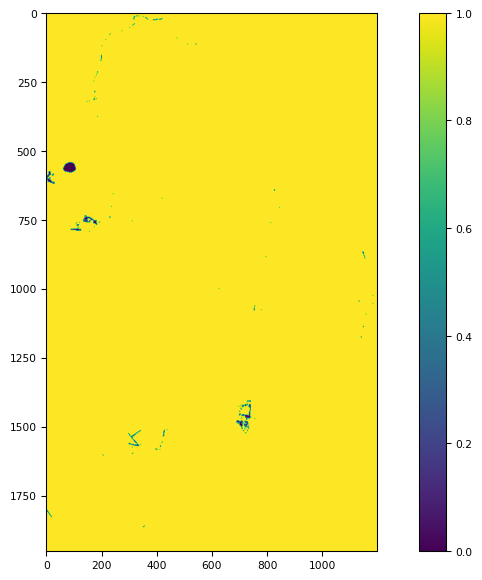

In [21]:
dataset = get_dataset(
    path_S2B, 
    channels_list=channels_list, 
    window=window, 
    visualise=True, 
    indices=True)

In [16]:
dataset.head(5)

,x,y,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,ndvi,ndwi,msr670800,evi,savi,arvi
0,0,0,206.0,342.0,159.0,635.0,2857.0,3691.0,3540.0,3999.0,1474.0,601.0,0.914031,0.412046,4.408638,2.865254,1.305085,0.923612
1,0,1,207.0,357.0,166.0,635.0,2857.0,3691.0,3772.0,3999.0,1474.0,601.0,0.915693,0.438048,4.459989,2.802736,1.307468,0.920371
2,0,2,204.0,363.0,161.0,618.0,2692.0,3465.0,3802.0,3754.0,1360.0,559.0,0.918748,0.473072,4.558224,2.810281,1.311831,0.917848
3,0,3,201.0,328.0,151.0,618.0,2692.0,3465.0,3392.0,3754.0,1360.0,559.0,0.914761,0.427609,4.431033,2.902561,1.306122,0.922768
4,0,4,197.0,309.0,153.0,587.0,2476.0,3098.0,3042.0,3386.0,1190.0,498.0,0.904225,0.437618,4.132058,2.908194,1.291061,0.913649


In [17]:
X = dataset.drop(labels=['x', 'y'], axis=1)

# Age prediction

In [6]:
from catboost import CatBoostRegressor

model_age = CatBoostRegressor()
model_age.load_model('weights/exp=sunny-fire-2_id=ocbziafk.json', 'json')

In [18]:
age_map = model_age.predict(X)

### Save and plot result

In [22]:
save_dataset_to_tif(
    dataset,
    window,
    model_age, 
    path_S2B, 
    f'age_pred.tif',
    None,
    no_data_value=-1,
    out_dtype=np.float32, 
    proba=False,
    gt=False)

  0%|          | 0/2337912 [00:00<?, ?it/s]

Saving to ./data/tile_UTM38N/20180730/age_b5d437a8.tif...


res.shape is (9452, 10345)


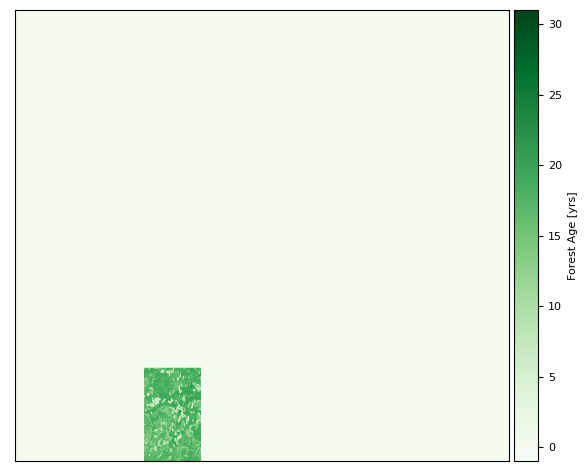

In [23]:
tif_age = Path(path_S2B) / 'age_pred.tif'
plot_res(tif_age, cbar_label = 'Forest Age [yrs]')

In [6]:
# save_map(age_map, dataset, path_S2B=path_S2B, out_name='catboost_10bands_age.tif')

Saved to ../../forest-disease/data/shelkopryad/images_DN_po-datam/20220630/catboost_10bands_age.tif
Out dtype: uint8


res.shape is (8514, 11066)


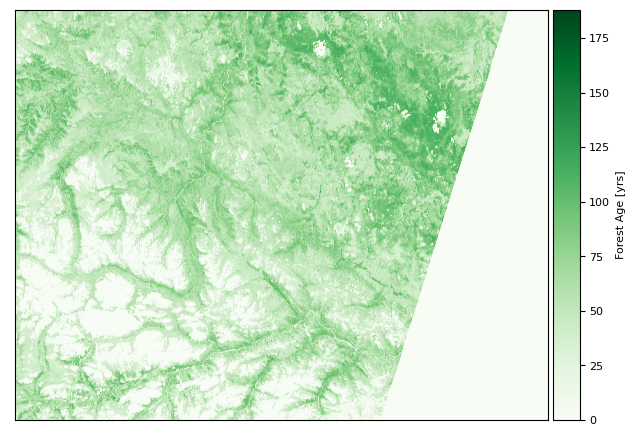

In [7]:
# tif_age = Path(path_S2B) / 'catboost_10bands_age.tif'
# plot_res(tif_age)

# Species prediction

In [24]:
from catboost import CatBoostClassifier


#load model for type prediction 
model_species = CatBoostClassifier()
model_species.load_model('weights/exp=vital-voice-5_id=ros2303p.json', 'json')

In [25]:
#predict type
species_map = model_species.predict(X)

In [30]:
model_species.classes_

array([1, 2, 3, 4, 5])

### Save and plot results

In [28]:
save_dataset_to_tif(
    dataset,
    window,
    model_species, 
    path_S2B, 
    f'species_pred.tif',
    None,
    no_data_value=-1,
    out_dtype=np.float32, 
    proba=False,
    gt=False)

  0%|          | 0/2337912 [00:00<?, ?it/s]

Saving to ./data/tile_UTM38N/20180730/species_6ddb8b70.tif...


data.shape is (9452, 10345)


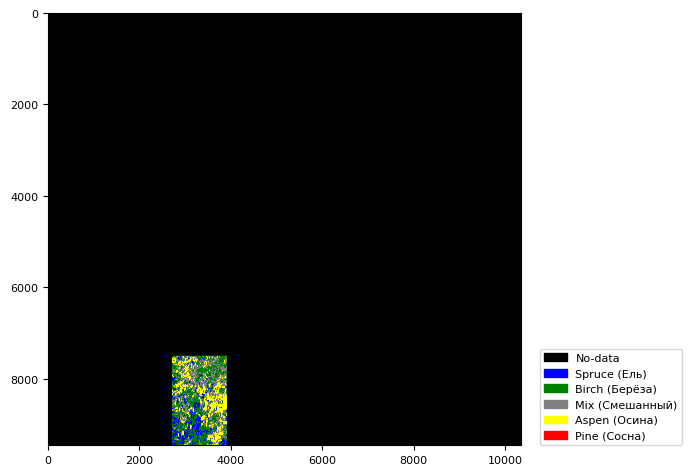

(array([1, 2, 3, 4, 5]), array([298980, 828021, 307345,  49243, 854323]))

In [31]:
tif_species = Path(path_S2B) / 'species_pred.tif'

species_legend = {
    -1: 'No-data',
    1: 'Spruce (Ель)',
    2: 'Birch (Берёза)',
    3: 'Mix (Смешанный)',
    4: 'Aspen (Осина)',
    5: 'Pine (Сосна)',
}

species_color_legend = {
    -1: 'black',
    1: 'blue',
    2: 'green',
    3: 'gray',
    4: 'yellow',
    5: 'red',
}

plot_mask(tif_species, species_legend, species_color_legend)

np.unique(species_map, return_counts=True)

# Timber prediction

## Height prediction

In [37]:
#load modelf for height prediction 
model_height = CatBoostRegressor()
model_height.load_model('weights/exp=sunny-fire-2_id=ocbziafk.json', 'json')

In [38]:
#predict height
height_map = model_height.predict(X)

### Save and plot result

In [39]:
save_dataset_to_tif(
    dataset,
    window,
    model_height, 
    path_S2B, 
    f'height_pred.tif',
    None,
    no_data_value=-1,
    out_dtype=np.float32, 
    proba=False,
    gt=False)

  0%|          | 0/2337912 [00:00<?, ?it/s]

Saving to ./data/tile_UTM38N/20180730/height_02d17977.tif...


res.shape is (9452, 10345)


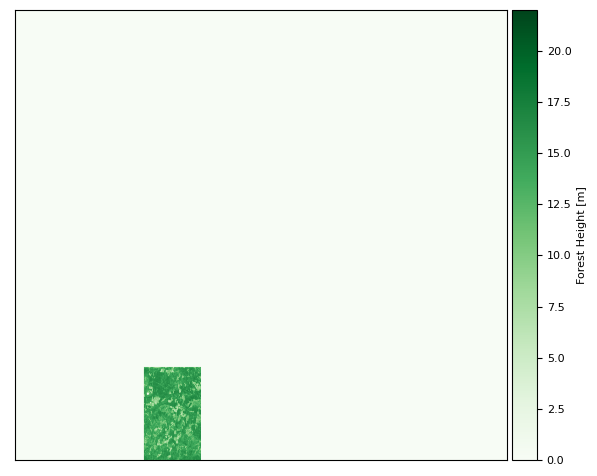

In [35]:
tif_age = Path(path_S2B) / 'height_pred.tif'
plot_res(tif_age, cbar_label = 'Forest Height [m]')

## Basal area prediction

In [41]:
#load modelf for area prediction 
model_area = CatBoostRegressor()
model_area.load_model('weights/exp=lucky-cloud-3_id=1yvpnq73.json', 'json')

In [42]:
#predict area
area_map = model_area.predict(X)

### Save and plot result

In [43]:
save_dataset_to_tif(
    dataset,
    window,
    model_area, 
    path_S2B, 
    f'basal-area_pred.tif',
    None,
    no_data_value=-1,
    out_dtype=np.float32, 
    proba=False,
    gt=False)

  0%|          | 0/2337912 [00:00<?, ?it/s]

Saving to ./data/tile_UTM38N/20180730/basal-area_c175edcf.tif...


res.shape is (9452, 10345)


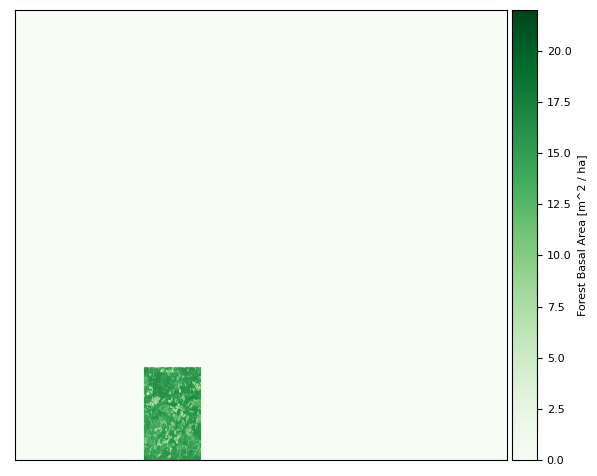

In [45]:
tif_age = Path(path_S2B) / 'basal-area_pred.tif'
plot_res(tif_age, cbar_label = 'Forest Basal Area [m^2 / ha]')

## Get timber stock

In [62]:
volume_dataset = dataset[['x', 'y']]
volume_dataset['area'] = area_map
volume_dataset['height'] = height_map
volume_dataset['stock'] = volume_dataset['area'] * volume_dataset['height']

volume_dataset = volume_dataset[(volume_dataset['area'] > 0) & (volume_dataset['height'] > 0)]

/trinity/home/alina.smolina/.conda/envs/co2_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/trinity/home/alina.smolina/.conda/envs/co2_v2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/trinity/home/alina.smolina/.conda/envs/co2_v2/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is try

In [70]:
save_dataset_to_tif(
    volume_dataset,
    window,
    None, 
    path_S2B, 
    f'timber-stock_pred.tif',
    'stock',
    no_data_value=-1,
    out_dtype=np.float32, 
    proba=False,
    gt=True
)

  0%|          | 0/2337906 [00:00<?, ?it/s]

Saving to ./data/tile_UTM38N/20180730/timber-stock_80b448e7.tif...


res.shape is (9452, 10345)


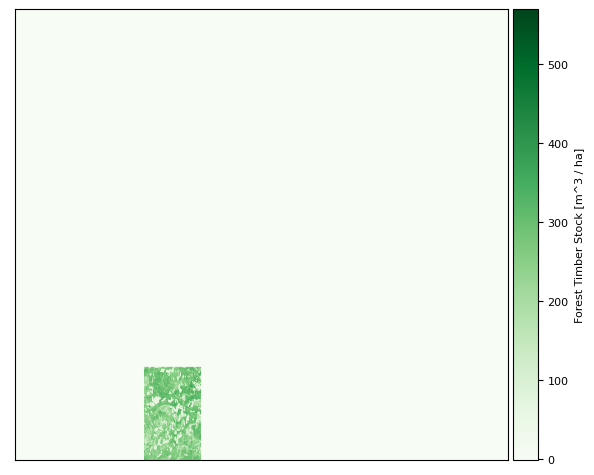

In [71]:
tif_age = Path(path_S2B) / 'timber-stock_pred.tif'
plot_res(tif_age, cbar_label = 'Forest Timber Stock [m^3 / ha]')

# Carbon Stock prediction

In [72]:
species_age = {4: [[0, 20], [20, 30], [30, 40], [40, 1000]], 
               2: [[0, 20], [20, 40], [40, 50], [50, 1000]], 
               1: [[0, 40], [40, 100], [100, 120], [120, 1000]], 
               5: [[0, 40], [40, 100], [100, 120], [120, 1000]],
               3: [[0, 40], [40, 100], [100, 120], [120, 1000]],
              }

species_coeff = {4: [0.403, 0.426, 0.431, 0.444], 
                2: [0.528, 0.534, 0.533, 0.528], 
                1: [0.409, 0.426, 0.431, 0.436], 
                5: [0.452, 0.454, 0.454, 0.449],
                3: [0.4, 0.4, 0.4, 0.4]}

C_content = {4: 0.47, 2: 0.47, 1: 0.5, 5: 0.5, 3: 0.47}

# mapping_col = {
#     'aspen': 5, # Осина
#     'spruce': 1, # Ель
#     'birch': 2, # Береза
#     'pine': 4, # Сосна
# }

In [74]:
BCEF_species = {5: np.zeros(age_map.shape), 2: np.zeros(age_map.shape), 1: np.zeros(age_map.shape), 4: np.zeros(age_map.shape)}
tmp_shape = np.ones(age_map.shape)

for sp in BCEF_species.keys():
    for age_ind in range(4):
        specimen_mask = np.where(species_map == sp, 1, 0) 
        BCEF_species[sp] += np.where((age_map > species_age[sp][age_ind][0] * tmp_shape) & (age_map <= species_age[sp][age_ind][1] * tmp_shape), 
                                     np.squeeze(specimen_mask*species_coeff[sp][age_ind]), 0)
    BCEF_species[sp] *= C_content[sp]


carbon_map = volume_map * (BCEF_species[5] + BCEF_species[2] + BCEF_species[1] + BCEF_species[4])
carbon_map = np.where(carbon_map > 0, carbon_map, 0)

In [76]:
carbon_dataset = dataset[['x', 'y']]
carbon_dataset['carbon_stock'] = carbon_map

/trinity/home/alina.smolina/.conda/envs/co2_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
save_dataset_to_tif(
    carbon_dataset,
    window,
    None, 
    path_S2B, 
    f'carbon-stock_pred.tif',
    'carbon_stock',
    no_data_value=-1,
    out_dtype=np.float32, 
    proba=False,
    gt=True
)

  0%|          | 0/2337912 [00:00<?, ?it/s]

Saving to ./data/tile_UTM38N/20180730/carbon-stock_bdadf85d.tif...


res.shape is (9452, 10345)


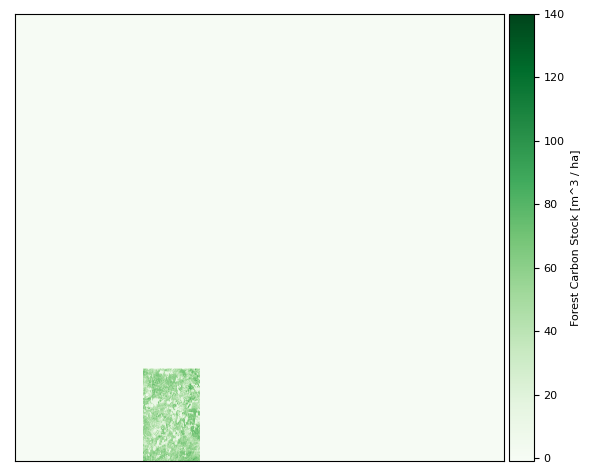

In [78]:
tif_age = Path(path_S2B) / 'carbon-stock_pred.tif'
plot_res(tif_age, cbar_label = 'Forest Carbon Stock [m^3 / ha]')